# Gesture Recognition Project
This project involves building a 3D Convolutional Neural Network (CNN) to correctly recognize hand gestures by a user to control a smart TV.


## Understanding the DataSet:

The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use. 

### Let's visualise the sample data for one of the action "thumbs-down" for one video (image-sequence)

### The data has been placed in the folder "Sample_Thumbs_Down" in current directory.



In [37]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

images = []
for img_path in glob.glob('Sample_Thumbs_Down/*.png'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(60,30))
columns = 10
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)

<Figure size 4320x2160 with 0 Axes>

In [43]:
# Doing the required imports :

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.losses import categorical_crossentropy
#from keras import optimizers
from tensorflow.keras import optimizers
from keras.layers.convolutional import Conv2D, MaxPooling3D, Conv3D, MaxPooling2D
from keras.layers.recurrent import GRU
from keras.layers import Activation, Dropout, ZeroPadding3D
from keras.layers.recurrent import LSTM

In [44]:
# Importing the python basic libraries and functions:
import numpy as np
import os
#from scipy.misc import imread, imresize
import datetime
import os

# Importing additional libraries which might be needed for image pre-processing :

#import resize as imresize
#import sckikit-image as skimage
import cv2
import imageio as imio
from PIL import Image

In [45]:
# Random seed is done to handle the reproducibility of the network and so that the results don't vary drastically:

In [46]:
np.random.seed(30)
import random as rn
rn.seed(30)

import tensorflow as tf
from keras import backend as K

import matplotlib.pyplot as plt

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [47]:
train_doc = np.random.permutation(open('datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('datasets/Project_data/val.csv').readlines())
batch_size=25

In [18]:
# Custom function to crop image :

def crop_img(img, scale=1.0):
    center_x, center_y = img.shape[1] / 2, img.shape[0] / 2
    width_scaled, height_scaled = img.shape[1] * scale, img.shape[0] * scale
    left_x, right_x = center_x - width_scaled / 2, center_x + width_scaled / 2
    top_y, bottom_y = center_y - height_scaled / 2, center_y + height_scaled / 2
    img_cropped = img[int(top_y):int(bottom_y), int(left_x):int(right_x)]
    return img_cropped

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. 

In [19]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
# calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
# we iterate over the number of batches
        for batch in range(num_batches): 
            
# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,18,64,64,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size    
            for folder in range(batch_size): 
# read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes

# Cropping image by 10 % of original size :
                    image = crop_img(image, 0.10)
    
# Resizing the image :    
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)                    
                        
#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,64,64,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
# Cropping image by 10 % of original size :
                    image = crop_img(image, 0.10)

# Resizing the image :
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)

# Perform normalization on images
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [20]:
curr_dt_time = datetime.datetime.now()
train_path = 'datasets/Project_data/train'
val_path = 'datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 5
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 5


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

# First Base Model : Conv 3D Model with 5 epochs, 25 batch size 
### Without dropouts in Conv layer and with batch normalization

### Input image size 64X64 , adam optimiser with learning rate 0.0002 with decay, 18 images as input out of 30 

In [23]:
# Building the first model which is 3D Conv model:

modelConv3D_1 = Sequential()

modelConv3D_1.add(Conv3D(8, (3,3,3), padding='same', input_shape=(18,64,64,3)))
modelConv3D_1.add(Activation('relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_1.add(Dropout(0.25))

modelConv3D_1.add(Conv3D(16, (3,3,3), padding='same'))
modelConv3D_1.add(Activation('relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_1.add(Dropout(0.25))

modelConv3D_1.add(Conv3D(32, (3,3,3), padding='same'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(Activation('relu'))
modelConv3D_1.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_1.add(Dropout(0.25))

modelConv3D_1.add(Conv3D(64, (3,3,3), padding='same'))
modelConv3D_1.add(Activation('relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_1.add(Dropout(0.25))

modelConv3D_1.add(Flatten())
modelConv3D_1.add(Dense(64, activation='relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(Dropout(0.25))

modelConv3D_1.add(Dense(64, activation='relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(Dropout(0.25))

modelConv3D_1.add(Dense(5, activation='softmax'))

#write your optimizer
optimiser = "adam"#write your optimizer
# compile model :
modelConv3D_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary :
print (modelConv3D_1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 18, 64, 64, 8)     656       
                                                                 
 activation_4 (Activation)   (None, 18, 64, 64, 8)     0         
                                                                 
 batch_normalization_6 (Batc  (None, 18, 64, 64, 8)    32        
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 9, 32, 32, 8)     0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 9, 32, 32, 16)     3472      
                                                                 
 activation_5 (Activation)   (None, 9, 32, 32, 16)    

In [24]:
print("Total Params in model:", modelConv3D_1.count_params())

Total Params in model: 144421


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [25]:
#write your optimizer
#optimiser = 
#sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
#model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#print (model.summary())

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [26]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [32]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [33]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [34]:
# Modified the fit generator to use multiproessing to improve the training time :

# This is for first model 3D Conv model: (modelConv3D_1)

history = modelConv3D_1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/5
27/27 [==============================] - ETA: 0s - loss: 1.6508 - categorical_accuracy: 0.3469
Epoch 00001: val_loss improved from inf to 1.77955, saving model to model_init_2024-05-0206_18_55.810623/model-00001-1.65083-0.34691-1.77955-0.24000.h5
27/27 [==============================] - 79s 3s/step - loss: 1.6508 - categorical_accuracy: 0.3469 - val_loss: 1.7795 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/5
27/27 [==============================] - ETA: 0s - loss: 1.6398 - categorical_accuracy: 0.3409
Epoch 00002: val_loss improved from 1.77955 to 1.69474, saving model to model_init_2024-05-0206_18_55.810623/model-00002-1.63979-0.34087-1.69474-0.24000.h5
27/27 [==============================] - 30s 1s/step - loss: 1.6398 - categorical_accuracy: 0.3409 - val_loss: 1.6947 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/5
27/27 [==============================] - ETA: 0s - loss: 1.6095 - categorical_accuracy: 0.3725
Epoch 00003: val_loss did not improve from 1.

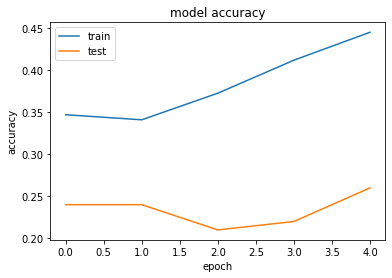

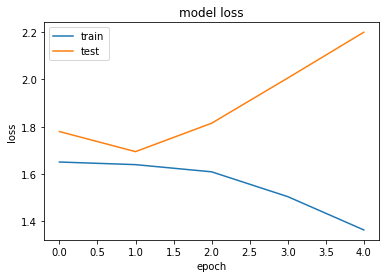

In [35]:
# Plotting the result of Model 1 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [38]:
model_detail_df = pd.DataFrame()
def model_result(model_name ,accuracy, loss, val_accuracy, val_loss):
    model_detail_dic = {"Model Name" : model_name,
                   "Model Accuracy" : accuracy * 100,
                   "Model Loss" : loss * 100 ,
                   "Val Accuracy" : val_accuracy * 100,
                   "Val Loss" : val_loss * 100}

    df = pd.DataFrame([model_detail_dic])
    return df

In [39]:
df1 = model_result("modelConv3D_1",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

      Model Name  Model Accuracy  Model Loss  Val Accuracy    Val Loss
0  modelConv3D_1       44.494721  136.417484     25.999999  219.879627


So we have got the training accuarcy of 44 % and validation accuracy of 25 % in the base model

# Second Model  : Conv 3D Model with 20 epochs, 30 batch size 
Without dropouts in Conv layer and with batch normalization.
Input image size 64X64 , adam optimiser with learning rate 0.0002 without decay, 18 images as input out of 30
Changed droput to 0.50 from 0.25 in 1st dense layer 

In [48]:
batch_size = 30
num_epochs = 20

In [49]:
# Building the second model which is 3D Conv model:

modelConv3D_2 = Sequential()

modelConv3D_2.add(Conv3D(8, (3,3,3), padding='same', input_shape=(18,64,64,3)))
modelConv3D_2.add(Activation('relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_2.add(Dropout(0.25))

modelConv3D_2.add(Conv3D(16, (3,3,3), padding='same'))
modelConv3D_2.add(Activation('relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_2.add(Dropout(0.25))

modelConv3D_2.add(Conv3D(32, (3,3,3), padding='same'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(Activation('relu'))
modelConv3D_2.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_2.add(Dropout(0.25))

modelConv3D_2.add(Conv3D(64, (3,3,3), padding='same'))
modelConv3D_2.add(Activation('relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_2.add(Dropout(0.25))

modelConv3D_2.add(Flatten())
modelConv3D_2.add(Dense(64, activation='relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(Dropout(0.50))

modelConv3D_2.add(Dense(64, activation='relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(Dropout(0.25))

modelConv3D_2.add(Dense(5, activation='softmax'))

#write your optimizer

optimiser = optimizers.Adam(lr=0.0002)
#write your optimizer
#optimiser = "adam"#write your optimizer


# compile model :
modelConv3D_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary :
print (modelConv3D_2.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 18, 64, 64, 8)     656       
                                                                 
 activation_16 (Activation)  (None, 18, 64, 64, 8)     0         
                                                                 
 batch_normalization_24 (Bat  (None, 18, 64, 64, 8)    32        
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 9, 32, 32, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 9, 32, 32, 16)     3472      
                                                                 
 activation_17 (Activation)  (None, 9, 32, 32, 16)    

In [50]:
print("Total Params in model:", modelConv3D_2.count_params())

Total Params in model: 144421


In [52]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose =1 )

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [54]:
# Modified the fit generator to use multiple worker without the multiprocessing training time :

# This is for second model 3D Conv model: )

history = modelConv3D_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,use_multiprocessing=False,
                     initial_epoch=0)

Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 2.0648 - categorical_accuracy: 0.2670Source path =  datasets/Project_data/val ; batch size = 30

Epoch 00001: val_loss improved from inf to 1.62748, saving model to model_init_2024-05-0206_18_55.810623/model-00001-2.06480-0.26697-1.62748-0.21000.h5
23/23 [==============================] - 24s 1s/step - loss: 2.0648 - categorical_accuracy: 0.2670 - val_loss: 1.6275 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.7840 - categorical_accuracy: 0.3303
Epoch 00002: val_loss did not improve from 1.62748
23/23 [==============================] - 24s 1s/step - loss: 1.7840 - categorical_accuracy: 0.3303 - val_loss: 1.7414 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 1.8160 - categorical_accuracy: 0.3047
Epoch 00003: val_loss did not improve from 1.62748
23/23 [======================

In [55]:
print("Total Params in model:", modelConv3D_2.count_params())

Total Params in model: 144421


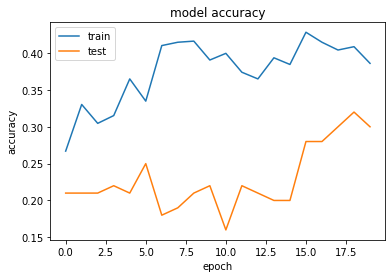

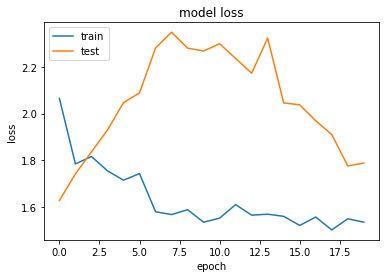

In [58]:
# Plotting the result of Model 2 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [59]:
df1 = model_result("modelConv3D_2",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

      Model Name  Model Accuracy  Model Loss  Val Accuracy    Val Loss
0  modelConv3D_1       44.494721  136.417484     25.999999  219.879627
0  modelConv3D_2       38.612369  153.423560     30.000001  178.754282
0  modelConv3D_2       38.612369  153.423560     30.000001  178.754282


# Third Model  : Conv 3D Model with 20 epochs and 30 batch size , image size increaed to 84X84, reduced cropping to 3 % from 10 %
Without dropouts in Conv layer and with batch normalization.
adam optimiser with learning rate 0.0002 without decay, 18 images as input out of 30
Reverted back dropout from 0.50 to 0.25 in 1st dense layer 

In [70]:
# Modified generator function :

def generator_modified(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [1,2,4,6,7,8,10,12,14,16,18,20,21,22,24,26,27,29]
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
# calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
# we iterate over the number of batches
        for batch in range(num_batches): 
            
# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,18,84,84,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size    
            for folder in range(batch_size): 
# read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes

# Cropping image by 3 % of original size :
                    image = crop_img(image, 0.03)
    
# Resizing the image :    
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)                    
                        
#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,84,84,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
# Cropping image by 3 % of original size :
                    image = crop_img(image, 0.03)

# Resizing the image :
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)

# Perform normalization on images
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels


In [71]:
curr_dt_time = datetime.datetime.now()
train_path = 'datasets/Project_data/train'
val_path = 'datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)

batch_size = 30
print ('# batch_size =', batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch_size = 30


In [72]:
# Building the  model which is 3D Conv model:

modelConv3D_3 = Sequential()

modelConv3D_3.add(Conv3D(8, (3,3,3), padding='same', input_shape=(18,84,84,3)))
modelConv3D_3.add(Activation('relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_3.add(Dropout(0.25))

modelConv3D_3.add(Conv3D(16, (3,3,3), padding='same'))
modelConv3D_3.add(Activation('relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_3.add(Dropout(0.25))

modelConv3D_3.add(Conv3D(32, (3,3,3), padding='same'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(Activation('relu'))
modelConv3D_3.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_3.add(Dropout(0.25))

modelConv3D_3.add(Conv3D(64, (3,3,3), padding='same'))
modelConv3D_3.add(Activation('relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_3.add(Dropout(0.25))

modelConv3D_3.add(Flatten())

modelConv3D_3.add(Dense(128, activation='relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(Dropout(0.25))

modelConv3D_3.add(Dense(64, activation='relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(Dropout(0.25))

modelConv3D_3.add(Dense(5, activation='softmax'))

#write your optimizer
optimiser = optimizers.Adam(lr=0.0002)
#optimiser = 
#sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)

# compile model :
modelConv3D_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary :
print (modelConv3D_3.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 18, 84, 84, 8)     656       
                                                                 
 activation_28 (Activation)  (None, 18, 84, 84, 8)     0         
                                                                 
 batch_normalization_42 (Bat  (None, 18, 84, 84, 8)    32        
 chNormalization)                                                
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 9, 42, 42, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_29 (Conv3D)          (None, 9, 42, 42, 16)     3472      
                                                                 
 activation_29 (Activation)  (None, 9, 42, 42, 16)    

In [73]:
print("Total Params in model:", modelConv3D_3.count_params())

Total Params in model: 288101


In [74]:
train_generator = generator_modified(train_path, train_doc, batch_size)
val_generator = generator_modified(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose =1)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [75]:
history = modelConv3D_3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 30
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 2.1473 - categorical_accuracy: 0.2519Source path =  datasets/Project_data/val ; batch size = 30

Epoch 00001: val_loss improved from inf to 1.69356, saving model to model_init_2024-05-0206_53_59.750890/model-00001-2.14726-0.25189-1.69356-0.22000.h5
23/23 [==============================] - 38s 2s/step - loss: 2.1473 - categorical_accuracy: 0.2519 - val_loss: 1.6936 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 2/20
22/23 [===========================>..] - ETA: 1s - loss: 1.8564 - categorical_accuracy: 0.3227
Epoch 00002: val_loss did not improve from 1.69356
23/23 [==============================] - 27s 1s/step - loss: 1.8545 - categorical_accuracy: 0.3228 - val_loss: 1.8437 - val_categorical_accuracy: 0.2400 - lr: 2.0000e-04
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 1.6913 - categorical_accuracy: 0.3484
Epoch 00003: val_lo

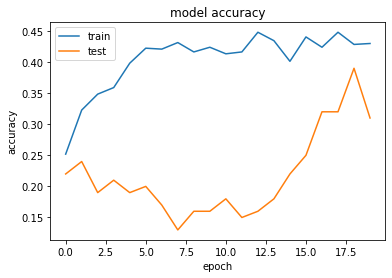

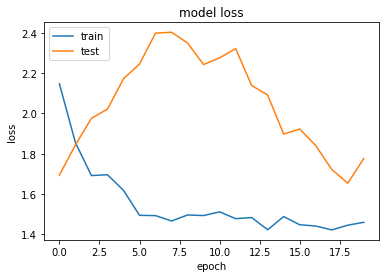

In [76]:
# Plotting the result of Model 3 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [77]:
df1 = model_result("modelConv3D_3",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

      Model Name  Model Accuracy  Model Loss  Val Accuracy    Val Loss
0  modelConv3D_1       44.494721  136.417484     25.999999  219.879627
0  modelConv3D_2       38.612369  153.423560     30.000001  178.754282
0  modelConv3D_2       38.612369  153.423560     30.000001  178.754282
0  modelConv3D_3       42.986426  145.889616     31.000000  177.600634


# Fourth Model : Conv 3D model 
## Increase the image size to 100x100, batch size 50, epoch 30

In [78]:
train_doc = np.random.permutation(open('datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('datasets/Project_data/val.csv').readlines())

In [79]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [1,2,4,6,7,8,10,12,14,16,18,20,21,22,24,26,27,29]
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
# calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
# we iterate over the number of batches
        for batch in range(num_batches): 
            
# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,18,100,100,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size    
            for folder in range(batch_size): 
# read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes

# Cropping image by 10 % of original size :
                    image = crop_img(image, 0.02)
    
# Resizing the image :    
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)                    
                        
#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,100,100,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
# Cropping image by 10 % of original size :
                    image = crop_img(image, 0.02)

# Resizing the image :
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)

# Perform normalization on images
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels


In [80]:
modelConv3D_4 = Sequential()

modelConv3D_4.add(Conv3D(8, 
                 kernel_size=(3,3,3), 
                 input_shape=(18,100,100,3),
                 padding='same'))
modelConv3D_4.add(BatchNormalization())
modelConv3D_4.add(Activation('relu'))

modelConv3D_4.add(MaxPooling3D(pool_size=(2,2,2)))

modelConv3D_4.add(Conv3D(16, 
                 kernel_size=(3,3,3), 
                 padding='same'))
modelConv3D_4.add(BatchNormalization())
modelConv3D_4.add(Activation('relu'))

modelConv3D_4.add(MaxPooling3D(pool_size=(2,2,2)))

modelConv3D_4.add(Conv3D(32, 
                 kernel_size=(1,3,3), 
                 padding='same'))
modelConv3D_4.add(BatchNormalization())
modelConv3D_4.add(Activation('relu'))

modelConv3D_4.add(MaxPooling3D(pool_size=(2,2,2)))

modelConv3D_4.add(Conv3D(64, 
                 kernel_size=(1,3,3), 
                 padding='same'))
modelConv3D_4.add(Activation('relu'))
modelConv3D_4.add(Dropout(0.25))

modelConv3D_4.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
modelConv3D_4.add(Flatten())

modelConv3D_4.add(Dense(256, activation='relu'))
modelConv3D_4.add(Dropout(0.25))

modelConv3D_4.add(Dense(128, activation='relu'))
modelConv3D_4.add(Dropout(0.25))

#softmax layer
modelConv3D_4.add(Dense(5, activation='softmax'))

In [82]:
#write your optimizer
optimiser = "adam"
modelConv3D_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (modelConv3D_4.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 18, 100, 100, 8)   656       
                                                                 
 batch_normalization_48 (Bat  (None, 18, 100, 100, 8)  32        
 chNormalization)                                                
                                                                 
 activation_32 (Activation)  (None, 18, 100, 100, 8)   0         
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 9, 50, 50, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_33 (Conv3D)          (None, 9, 50, 50, 16)     3472      
                                                                 
 batch_normalization_49 (Bat  (None, 9, 50, 50, 16)   

In [83]:
print("Total Params in model:", modelConv3D_4.count_params())

Total Params in model: 651109


In [84]:
curr_dt_time = datetime.datetime.now()
train_path = 'datasets/Project_data/train'
val_path = 'datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

batch_size = 50
num_epochs = 30

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

# training sequences = 663
# validation sequences = 100


In [85]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

# write the Reducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

In [87]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
history = modelConv3D_4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)


Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 1.6232 - categorical_accuracy: 0.2549Source path =  datasets/Project_data/val ; batch size = 50

Epoch 00001: val_loss improved from inf to 1.60384, saving model to model_init_2024-05-0207_08_55.566511/model-00001-1.62324-0.25490-1.60384-0.20000.h5
14/14 [==============================] - 27s 2s/step - loss: 1.6232 - categorical_accuracy: 0.2549 - val_loss: 1.6038 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 1.5413 - categorical_accuracy: 0.3017
Epoch 00002: val_loss did not improve from 1.60384
14/14 [==============================] - 27s 2s/step - loss: 1.5413 - categorical_accuracy: 0.3017 - val_loss: 1.6166 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/30
14/14 [==============================] - ETA: 0s - loss: 1.4908 - categorical_accuracy: 0.3680
Epoch 00003: val_loss did not improve from 1.60384

Epoch 00003: ReduceLROnPlateau reduc

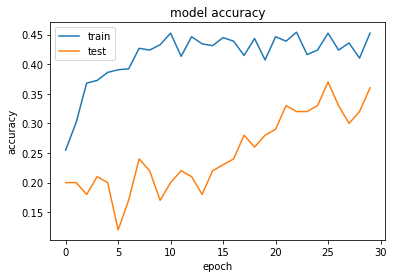

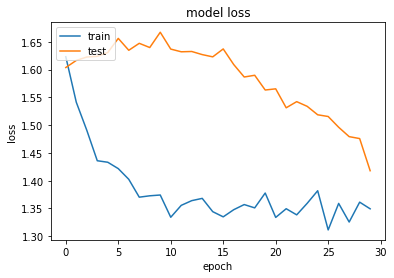

In [89]:
# Plotting the result of Model 4 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [90]:
df1 = model_result("modelConv3D_4",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

      Model Name  Model Accuracy  Model Loss  Val Accuracy    Val Loss
0  modelConv3D_1       44.494721  136.417484     25.999999  219.879627
0  modelConv3D_2       38.612369  153.423560     30.000001  178.754282
0  modelConv3D_2       38.612369  153.423560     30.000001  178.754282
0  modelConv3D_3       42.986426  145.889616     31.000000  177.600634
0  modelConv3D_4       45.248869  134.927368     36.000001  141.790569


# Model 5 : Conv 3D model

## batch size 30, increased image inputs to 30 , image size recuced to 84

In [91]:
batch_size = 30

In [92]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [x for x in range(0, 30)] 
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
# calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
# we iterate over the number of batches
        for batch in range(num_batches): 
            
# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,30,84,84,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size    
            for folder in range(batch_size): 
# read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                                
#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,30,84,84,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [93]:
curr_dt_time = datetime.datetime.now()
train_path = 'datasets/Project_data/train'
val_path = 'datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 30
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


In [95]:

#write your model here

modelConv3D_5 = Sequential()

modelConv3D_5.add(Conv3D(8, (3,3,3), padding='same', input_shape=(30,84,84,3)))
modelConv3D_5.add(Activation('relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_5.add(Dropout(0.25))

modelConv3D_5.add(Conv3D(16, (3,3,3), padding='same'))
modelConv3D_5.add(Activation('relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_5.add(Dropout(0.25))

modelConv3D_5.add(Conv3D(32, (3,3,3), padding='same'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(Activation('relu'))
modelConv3D_5.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_5.add(Dropout(0.25))

modelConv3D_5.add(Conv3D(64, (3,3,3), padding='same'))
modelConv3D_5.add(Activation('relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_5.add(Dropout(0.25))

modelConv3D_5.add(Flatten())
modelConv3D_5.add(Dense(64, activation='relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(Dropout(0.25))

modelConv3D_5.add(Dense(64, activation='relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(Dropout(0.25))

modelConv3D_5.add(Dense(5, activation='softmax'))

#write your optimizer
optimiser = optimizers.Adam(lr=0.0002)
#optimiser = 
#sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)

# compile model :
modelConv3D_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (modelConv3D_5.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_40 (Conv3D)          (None, 30, 84, 84, 8)     656       
                                                                 
 activation_40 (Activation)  (None, 30, 84, 84, 8)     0         
                                                                 
 batch_normalization_57 (Bat  (None, 30, 84, 84, 8)    32        
 chNormalization)                                                
                                                                 
 max_pooling3d_40 (MaxPoolin  (None, 15, 42, 42, 8)    0         
 g3D)                                                            
                                                                 
 conv3d_41 (Conv3D)          (None, 15, 42, 42, 16)    3472      
                                                                 
 activation_41 (Activation)  (None, 15, 42, 42, 16)  

In [96]:
print("Total Params in model:", modelConv3D_5.count_params())

Total Params in model: 181285


In [98]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [99]:
history = modelConv3D_5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,  initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 2.1996 - categorical_accuracy: 0.2504Source path =  datasets/Project_data/val ; batch size = 30

Epoch 00001: val_loss improved from inf to 1.62823, saving model to model_init_2024-05-0207_29_12.960563/model-00001-2.19965-0.25038-1.62823-0.21000.h5
23/23 [==============================] - 49s 2s/step - loss: 2.1996 - categorical_accuracy: 0.2504 - val_loss: 1.6282 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.6578 - categorical_accuracy: 0.4178
Epoch 00002: val_loss did not improve from 1.62823
23/23 [==============================] - 47s 2s/step - loss: 1.6578 - categorical_accuracy: 0.4178 - val_loss: 1.7394 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.4578 - categorical_accuracy: 0.4661
Epoch 00003: val_lo

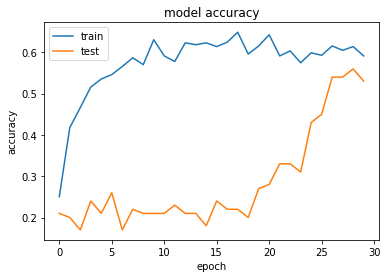

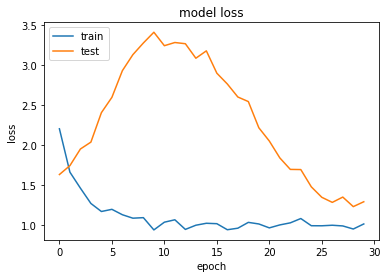

In [101]:
# Plotting the result of Model 5 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [102]:
df1 = model_result("modelConv3D_5",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

      Model Name  Model Accuracy  Model Loss  Val Accuracy    Val Loss
0  modelConv3D_1       44.494721  136.417484     25.999999  219.879627
0  modelConv3D_2       38.612369  153.423560     30.000001  178.754282
0  modelConv3D_2       38.612369  153.423560     30.000001  178.754282
0  modelConv3D_3       42.986426  145.889616     31.000000  177.600634
0  modelConv3D_4       45.248869  134.927368     36.000001  141.790569
0  modelConv3D_5       59.125191  101.061988     52.999997  128.816605


### _We have tried multiple experiments with Conv 3D model but the performance of models are not as expected, so lets try with the other models for the same problem statement._

# Model 6 : CNN - LSTM Model 

In [103]:
# Input
input_shape=(30,120,120,3)

In [104]:

#write your model here
CNNlstm_1 = Sequential()

CNNlstm_1.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=input_shape))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_1.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_1.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_1.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_1.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_1.add(TimeDistributed(Flatten()))


CNNlstm_1.add(LSTM(128))
CNNlstm_1.add(Dropout(0.25))

CNNlstm_1.add(Dense(128,activation='relu'))
CNNlstm_1.add(Dropout(0.25))

CNNlstm_1.add(Dense(5, activation='softmax'))


#write your optimizer
optimiser = optimizers.Adam()
#optimiser = 
#sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)

# compile model :
CNNlstm_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (CNNlstm_1.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 60, 60, 32) 

In [106]:
batch_size = 20
curr_dt_time = datetime.datetime.now()
train_path = 'datasets/Project_data/train'
val_path = 'datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)


# training sequences = 663
# validation sequences = 100
# epochs = 20


In [107]:
def generatorLSTM(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [x for x in range(0, 30)]
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
# calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
# we iterate over the number of batches
        for batch in range(num_batches): 
            
# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,30,120,120,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size    
            for folder in range(batch_size): 
# read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                                
#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,30,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [108]:
train_generator = generatorLSTM(train_path, train_doc, batch_size)
val_generator = generatorLSTM(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [109]:
history = CNNlstm_1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4196 - categorical_accuracy: 0.3786Source path =  datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 1.80863, saving model to model_init_2024-05-0207_59_41.276742/model-00001-1.41965-0.37858-1.80863-0.21000.h5
34/34 [==============================] - 54s 2s/step - loss: 1.4196 - categorical_accuracy: 0.3786 - val_loss: 1.8086 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1993 - categorical_accuracy: 0.4766
Epoch 00002: val_loss did not improve from 1.80863
34/34 [==============================] - 51s 2s/step - loss: 1.1993 - categorical_accuracy: 0.4766 - val_loss: 1.9025 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.1222 - categorical_accuracy: 0.5264
Epoch 00003: val_loss did n

In [111]:
print("Total Params in model:", CNNlstm_1.count_params())

Total Params in model: 1657445


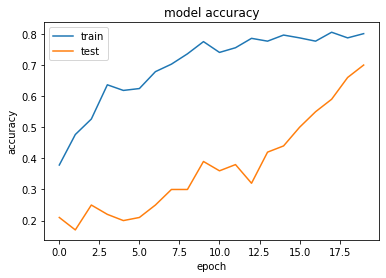

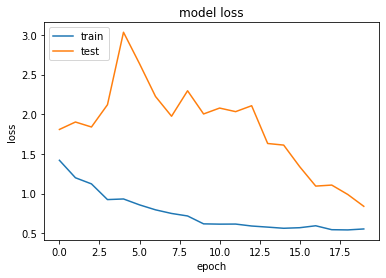

In [112]:
# Plotting the result of Model 6 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [154]:
df1 = model_result("CNNlstm_1",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

      Model Name  Model Accuracy  Model Loss  Val Accuracy    Val Loss
0  modelConv3D_1       44.494721  136.417484     25.999999  219.879627
0  modelConv3D_2       38.612369  153.423560     30.000001  178.754282
0  modelConv3D_2       38.612369  153.423560     30.000001  178.754282
0  modelConv3D_3       42.986426  145.889616     31.000000  177.600634
0  modelConv3D_4       45.248869  134.927368     36.000001  141.790569
0  modelConv3D_5       59.125191  101.061988     52.999997  128.816605
0  modelConv3D_6       80.090499   55.362916     69.999999   83.913064
0      CNNlstm_1       92.458522   25.206617     77.999997   66.047078


# Model 7 : CNN - LSTM Model , Increase layers , increase epoch to 25

In [147]:
input_shape=(30,120,120,3)

CNNlstm_2 = Sequential()
CNNlstm_2.add(Conv3D(16, (3,3,3), padding='same',
         input_shape=(input_shape)))
CNNlstm_2.add(Activation('relu'))
CNNlstm_2.add(BatchNormalization())

CNNlstm_2.add(Conv3D(16, (3,3,3), padding='same',
         input_shape=(input_shape)))
CNNlstm_2.add(Activation('relu'))
CNNlstm_2.add(BatchNormalization())

CNNlstm_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

CNNlstm_2.add(Conv3D(32, (3,3,3), padding='same'))
CNNlstm_2.add(Activation('relu'))
CNNlstm_2.add(BatchNormalization())

CNNlstm_2.add(Conv3D(32, (3,3,3), padding='same'))
CNNlstm_2.add(Activation('relu'))
CNNlstm_2.add(BatchNormalization())

CNNlstm_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

CNNlstm_2.add(Conv3D(64, (3,3,3), padding='same'))
CNNlstm_2.add(Activation('relu'))
CNNlstm_2.add(BatchNormalization())

CNNlstm_2.add(Conv3D(64, (3,3,3), padding='same'))
CNNlstm_2.add(Activation('relu'))
CNNlstm_2.add(BatchNormalization())

CNNlstm_2.add(MaxPooling3D(pool_size=(2, 2, 2)))

CNNlstm_2.add(Conv3D(128, (3,3,3), padding='same'))
CNNlstm_2.add(Activation('relu'))
CNNlstm_2.add(BatchNormalization())

CNNlstm_2.add(Conv3D(128, (3,3,3), padding='same'))
CNNlstm_2.add(Activation('relu'))
CNNlstm_2.add(BatchNormalization())
CNNlstm_2.add(MaxPooling3D(pool_size=(2, 2, 2)))


CNNlstm_2.add(Flatten())
CNNlstm_2.add(Dense(64,activation='relu'))
CNNlstm_2.add(BatchNormalization())
CNNlstm_2.add(Dropout(0.25))

CNNlstm_2.add(Dense(64,activation='relu'))
CNNlstm_2.add(BatchNormalization())
CNNlstm_2.add(Dropout(0.25))


CNNlstm_2.add(Dense(5,activation='softmax'))

optimiser = optimizers.Adam()
CNNlstm_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (CNNlstm_2.summary())

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_52 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_52 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_98 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_53 (Conv3D)          (None, 30, 120, 120, 16)  6928      
                                                                 
 activation_53 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_99 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                    

In [148]:
print("Total Params in model:", CNNlstm_2.count_params())

Total Params in model: 1287989


In [149]:
batch_size = 20
curr_dt_time = datetime.datetime.now()
train_path = 'datasets/Project_data/train'
val_path = 'datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 25
print ('# epochs =', num_epochs)


# training sequences = 663
# validation sequences = 100
# epochs = 25


In [150]:
train_generator = generatorLSTM(train_path, train_doc, batch_size)
val_generator = generatorLSTM(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [151]:
history = CNNlstm_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,  initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.5786 - categorical_accuracy: 0.3756Source path =  datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 3.36985, saving model to model_init_2024-05-0209_13_07.991341/model-00001-1.57862-0.37557-3.36985-0.23000.h5
34/34 [==============================] - 105s 3s/step - loss: 1.5786 - categorical_accuracy: 0.3756 - val_loss: 3.3698 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.3213 - categorical_accuracy: 0.4932
Epoch 00002: val_loss improved from 3.36985 to 2.66077, saving model to model_init_2024-05-0209_13_07.991341/model-00002-1.32135-0.49321-2.66077-0.17000.h5
34/34 [==============================] - 74s 2s/step - loss: 1.3213 - categorical_accuracy: 0.4932 - val_loss: 2.6608 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/25
34/34 [=========

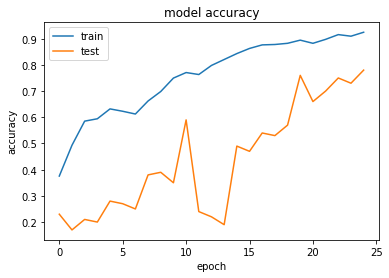

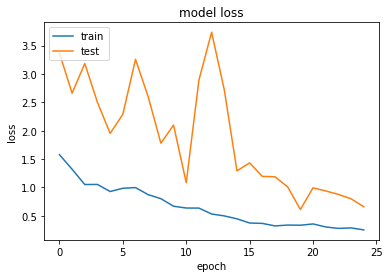

In [153]:
# Plotting the result of Model 7 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [155]:
df1 = model_result("CNNlstm_2",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

      Model Name  Model Accuracy  Model Loss  Val Accuracy    Val Loss
0  modelConv3D_1       44.494721  136.417484     25.999999  219.879627
0  modelConv3D_2       38.612369  153.423560     30.000001  178.754282
0  modelConv3D_2       38.612369  153.423560     30.000001  178.754282
0  modelConv3D_3       42.986426  145.889616     31.000000  177.600634
0  modelConv3D_4       45.248869  134.927368     36.000001  141.790569
0  modelConv3D_5       59.125191  101.061988     52.999997  128.816605
0  modelConv3D_6       80.090499   55.362916     69.999999   83.913064
0      CNNlstm_1       92.458522   25.206617     77.999997   66.047078
0      CNNlstm_2       92.458522   25.206617     77.999997   66.047078


# Model 8 : CNN - LSTM Model, Increase network paramaters

In [158]:
input_shape=(30,120,120,3)

CNNlstm_3 = Sequential()
CNNlstm_3.add(Conv3D(16, (3,3,3), padding='same',
         input_shape=(input_shape)))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(Conv3D(16, (3,3,3), padding='same',
         input_shape=(input_shape)))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

CNNlstm_3.add(Conv3D(32, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(Conv3D(32, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

CNNlstm_3.add(Conv3D(64, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(Conv3D(64, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

CNNlstm_3.add(Conv3D(128, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(Conv3D(128, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())
CNNlstm_3.add(MaxPooling3D(pool_size=(2, 2, 2)))


CNNlstm_3.add(Flatten())
CNNlstm_3.add(Dense(128,activation='relu'))
CNNlstm_3.add(BatchNormalization())
CNNlstm_3.add(Dropout(0.25))

CNNlstm_3.add(Dense(128,activation='relu'))
CNNlstm_3.add(BatchNormalization())
CNNlstm_3.add(Dropout(0.25))


CNNlstm_3.add(Dense(5,activation='softmax'))

optimiser = optimizers.Adam()
CNNlstm_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print (CNNlstm_3.summary())

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_68 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_68 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_118 (Ba  (None, 30, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 conv3d_69 (Conv3D)          (None, 30, 120, 120, 16)  6928      
                                                                 
 activation_69 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_119 (Ba  (None, 30, 120, 120, 16)  64       
 tchNormalization)                                   

In [159]:
print("Total Params in model:", CNNlstm_3.count_params())

Total Params in model: 1702645


In [160]:
batch_size = 20
curr_dt_time = datetime.datetime.now()
train_path = 'datasets/Project_data/train'
val_path = 'datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 25
print ('# epochs =', num_epochs)


# training sequences = 663
# validation sequences = 100
# epochs = 25


In [161]:
train_generator = generatorLSTM(train_path, train_doc, batch_size)
val_generator = generatorLSTM(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only= True, mode='auto')

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [162]:
history = CNNlstm_3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.6017 - categorical_accuracy: 0.3891Source path =  datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2024-05-0209_40_17.312999/model-00001-1.60167-0.38914-3.67718-0.21000.h5
34/34 [==============================] - 87s 3s/step - loss: 1.6017 - categorical_accuracy: 0.3891 - val_loss: 3.6772 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.2512 - categorical_accuracy: 0.5053
Epoch 00002: saving model to model_init_2024-05-0209_40_17.312999/model-00002-1.25122-0.50528-2.94417-0.22000.h5
34/34 [==============================] - 49s 1s/step - loss: 1.2512 - categorical_accuracy: 0.5053 - val_loss: 2.9442 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.1135 - categorical_accuracy: 0.5596
Epoc

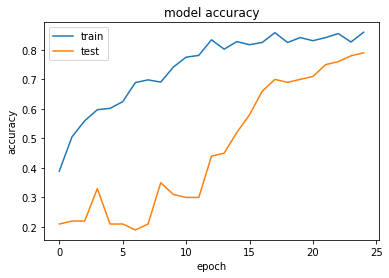

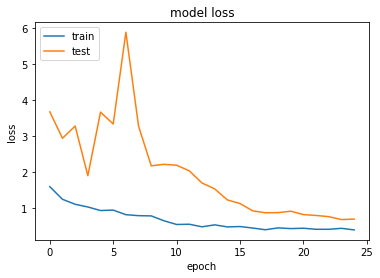

In [163]:
# Plotting the result of Model 8 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [164]:
df1 = model_result("CNNlstm_3",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

      Model Name  Model Accuracy  Model Loss  Val Accuracy    Val Loss
0  modelConv3D_1       44.494721  136.417484     25.999999  219.879627
0  modelConv3D_2       38.612369  153.423560     30.000001  178.754282
0  modelConv3D_2       38.612369  153.423560     30.000001  178.754282
0  modelConv3D_3       42.986426  145.889616     31.000000  177.600634
0  modelConv3D_4       45.248869  134.927368     36.000001  141.790569
0  modelConv3D_5       59.125191  101.061988     52.999997  128.816605
0  modelConv3D_6       80.090499   55.362916     69.999999   83.913064
0      CNNlstm_1       92.458522   25.206617     77.999997   66.047078
0      CNNlstm_2       92.458522   25.206617     77.999997   66.047078
0      CNNlstm_3       85.972852   40.237352     79.000002   70.206344


# Model 9 : CNN LSTM with GRU

In [168]:
input_shape=(30,120,120,3)

GRU_lstm = Sequential()

GRU_lstm.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(input_shape)))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

GRU_lstm.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

GRU_lstm.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

GRU_lstm.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))


GRU_lstm.add(TimeDistributed(Flatten()))


GRU_lstm.add(GRU(128))
GRU_lstm.add(Dropout(0.25))

GRU_lstm.add(Dense(128,activation='relu'))
GRU_lstm.add(Dropout(0.25))

GRU_lstm.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam()
GRU_lstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (GRU_lstm.summary())

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_93 (TimeDi  (None, 30, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_94 (TimeDi  (None, 30, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_95 (TimeDi  (None, 30, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_96 (TimeDi  (None, 30, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_97 (TimeDi  (None, 30, 60, 60, 32) 

In [169]:
print("Total Params in model:", GRU_lstm.count_params())

Total Params in model: 2573541


In [170]:
batch_size = 20
curr_dt_time = datetime.datetime.now()
train_path = 'datasets/Project_data/train'
val_path = 'datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)


# training sequences = 663
# validation sequences = 100
# epochs = 20


In [171]:
train_generator = generatorLSTM(train_path, train_doc, batch_size)
val_generator = generatorLSTM(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [172]:
history = GRU_lstm.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.5348 - categorical_accuracy: 0.3544Source path =  datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 2.30373, saving model to model_init_2024-05-0210_12_51.588914/model-00001-1.53477-0.35445-2.30373-0.30000.h5
34/34 [==============================] - 53s 2s/step - loss: 1.5348 - categorical_accuracy: 0.3544 - val_loss: 2.3037 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.2651 - categorical_accuracy: 0.4630
Epoch 00002: val_loss did not improve from 2.30373
34/34 [==============================] - 50s 2s/step - loss: 1.2651 - categorical_accuracy: 0.4630 - val_loss: 2.8042 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.1068 - categorical_accuracy: 0.5158
Epoch 00003: val_loss did n

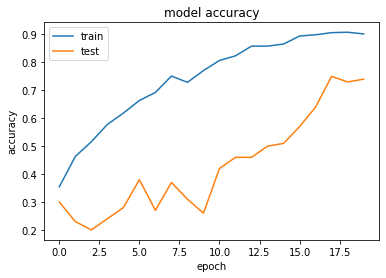

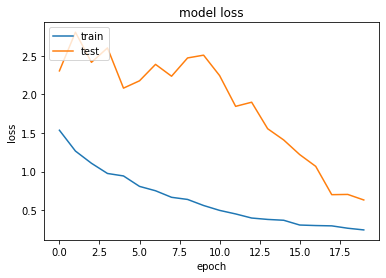

In [175]:
# Plotting the result of Model 9:

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [174]:
df1 = model_result("GRU_lstm",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

      Model Name  Model Accuracy  Model Loss  Val Accuracy    Val Loss
0  modelConv3D_1       44.494721  136.417484     25.999999  219.879627
0  modelConv3D_2       38.612369  153.423560     30.000001  178.754282
0  modelConv3D_2       38.612369  153.423560     30.000001  178.754282
0  modelConv3D_3       42.986426  145.889616     31.000000  177.600634
0  modelConv3D_4       45.248869  134.927368     36.000001  141.790569
0  modelConv3D_5       59.125191  101.061988     52.999997  128.816605
0  modelConv3D_6       80.090499   55.362916     69.999999   83.913064
0      CNNlstm_1       92.458522   25.206617     77.999997   66.047078
0      CNNlstm_2       92.458522   25.206617     77.999997   66.047078
0      CNNlstm_3       85.972852   40.237352     79.000002   70.206344
0       GRU_lstm       90.196079   24.359199     74.000001   63.145792


### Lets use the pre-trained model for the transfer learning.

# Model 10: Model with Transfer Learning

In [176]:
# Importing the transfer learning model:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

17235968/17225924 [==============================] - 2s 0us/step


In [177]:
# MobileNet V2 model accepts one of the following formats: (96, 96), (128, 128), (160, 160),(192, 192), or (224, 224).
# Hence, we have got this warning for the input as we have not specified the input size while import.

In [178]:
# Building the model :

input_shape = (18,120,120,3)
        
mobileNetModel= Sequential()
mobileNetModel.add(TimeDistributed(mobilenet_transfer,input_shape=(input_shape)))


for layer in mobileNetModel.layers:
    layer.trainable = False


mobileNetModel.add(TimeDistributed(BatchNormalization()))
mobileNetModel.add(TimeDistributed(MaxPooling2D((2, 2))))
mobileNetModel.add(TimeDistributed(Flatten()))

mobileNetModel.add(LSTM(128))
mobileNetModel.add(Dropout(0.25))

mobileNetModel.add(Dense(128,activation='relu'))
mobileNetModel.add(Dropout(0.25))

mobileNetModel.add(Dense(5, activation='softmax'))


optimiser = optimizers.Adam()
mobileNetModel.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (mobileNetModel.summary())

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_106 (TimeD  (None, 18, 3, 3, 1024)   3228864   
 istributed)                                                     
                                                                 
 time_distributed_107 (TimeD  (None, 18, 3, 3, 1024)   4096      
 istributed)                                                     
                                                                 
 time_distributed_108 (TimeD  (None, 18, 1, 1, 1024)   0         
 istributed)                                                     
                                                                 
 time_distributed_109 (TimeD  (None, 18, 1024)         0         
 istributed)                                                     
                                                                 
 lstm_5 (LSTM)               (None, 128)             

In [179]:
print("Total Params in model:", mobileNetModel.count_params())

Total Params in model: 3840453


In [180]:
def generatorMobileNet(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [1,2,4,6,7,8,10,12,14,16,18,20,21,22,24,26,27,29]
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
# calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
# we iterate over the number of batches
        for batch in range(num_batches): 
            
# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,18,120,120,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size    
            for folder in range(batch_size): 
# read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                                
#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [181]:
batch_size = 5
curr_dt_time = datetime.datetime.now()
train_path = 'datasets/Project_data/train'
val_path = 'datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)


# training sequences = 663
# validation sequences = 100
# epochs = 20


In [182]:
train_generator = generatorMobileNet(train_path, train_doc, batch_size)
val_generator = generatorMobileNet(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [183]:
history = mobileNetModel.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 5
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.4017 - categorical_accuracy: 0.3982Source path =  datasets/Project_data/val ; batch size = 5

Epoch 00001: val_loss improved from inf to 1.09817, saving model to model_init_2024-05-0210_41_24.647740/model-00001-1.40171-0.39819-1.09817-0.54000.h5
133/133 [==============================] - 39s 267ms/step - loss: 1.4017 - categorical_accuracy: 0.3982 - val_loss: 1.0982 - val_categorical_accuracy: 0.5400 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.9325 - categorical_accuracy: 0.6410
Epoch 00002: val_loss improved from 1.09817 to 0.87388, saving model to model_init_2024-05-0210_41_24.647740/model-00002-0.93249-0.64103-0.87388-0.64000.h5
133/133 [==============================] - 33s 252ms/step - loss: 0.9325 - categorical_accuracy: 0.6410 - val_loss: 0.8739 - val_categorical_accuracy: 0.6400 - lr: 0.0010
Epoch 3/20
133/1

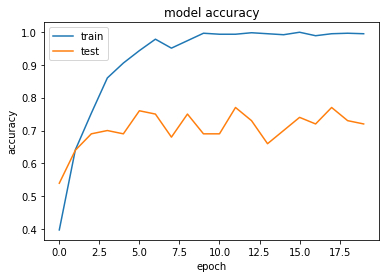

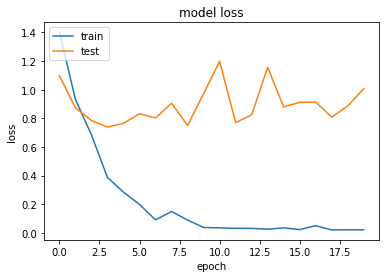

In [184]:
# Plotting the result of Model 10:

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [185]:
df1 = model_result("mobileNetModel",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

       Model Name  Model Accuracy  Model Loss  Val Accuracy    Val Loss
0   modelConv3D_1       44.494721  136.417484     25.999999  219.879627
0   modelConv3D_2       38.612369  153.423560     30.000001  178.754282
0   modelConv3D_2       38.612369  153.423560     30.000001  178.754282
0   modelConv3D_3       42.986426  145.889616     31.000000  177.600634
0   modelConv3D_4       45.248869  134.927368     36.000001  141.790569
0   modelConv3D_5       59.125191  101.061988     52.999997  128.816605
0   modelConv3D_6       80.090499   55.362916     69.999999   83.913064
0       CNNlstm_1       92.458522   25.206617     77.999997   66.047078
0       CNNlstm_2       92.458522   25.206617     77.999997   66.047078
0       CNNlstm_3       85.972852   40.237352     79.000002   70.206344
0        GRU_lstm       90.196079   24.359199     74.000001   63.145792
0  mobileNetModel       99.396682    2.035408     72.000003  100.715208


# Model 11: Transfer Learning with GRU and training all weights

In [186]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

input_shape = (18,120,120,3)
        
mobileNetModelWeight = Sequential()
mobileNetModelWeight.add(TimeDistributed(mobilenet_transfer,input_shape=(input_shape)))


mobileNetModelWeight.add(TimeDistributed(BatchNormalization()))
mobileNetModelWeight.add(TimeDistributed(MaxPooling2D((2, 2))))
mobileNetModelWeight.add(TimeDistributed(Flatten()))

mobileNetModelWeight.add(GRU(128))
mobileNetModelWeight.add(Dropout(0.25))

mobileNetModelWeight.add(Dense(128,activation='relu'))
mobileNetModelWeight.add(Dropout(0.25))

mobileNetModelWeight.add(Dense(5, activation='softmax'))


optimiser = optimizers.Adam()
mobileNetModelWeight.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (mobileNetModel.summary())

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_106 (TimeD  (None, 18, 3, 3, 1024)   3228864   
 istributed)                                                     
                                                                 
 time_distributed_107 (TimeD  (None, 18, 3, 3, 1024)   4096      
 istributed)                                                     
                                                                 
 time_distributed_108 (TimeD  (None, 18, 1, 1, 1024)   0         
 istributed)                                                     
                                                                 
 time_distributed_109 (TimeD  (None, 18, 1024)         0         
 istributed)                                                     
                                                                 
 lstm_5 (LSTM)               (None, 128)             

In [187]:
print("Total Params in model:", mobileNetModel.count_params())

Total Params in model: 3840453


In [189]:
batch_size = 5
curr_dt_time = datetime.datetime.now()
train_path = 'datasets/Project_data/train'
val_path = 'datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)


# training sequences = 663
# validation sequences = 100
# epochs = 20


In [190]:
train_generator = generatorMobileNet(train_path, train_doc, batch_size)
val_generator = generatorMobileNet(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [191]:
history = mobileNetModelWeight.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 5
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.3917 - categorical_accuracy: 0.4223Source path =  datasets/Project_data/val ; batch size = 5

Epoch 00001: val_loss improved from inf to 1.01594, saving model to model_init_2024-05-0210_58_33.922156/model-00001-1.39170-0.42232-1.01594-0.58000.h5
133/133 [==============================] - 40s 267ms/step - loss: 1.3917 - categorical_accuracy: 0.4223 - val_loss: 1.0159 - val_categorical_accuracy: 0.5800 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.9304 - categorical_accuracy: 0.6425
Epoch 00002: val_loss improved from 1.01594 to 0.58327, saving model to model_init_2024-05-0210_58_33.922156/model-00002-0.93044-0.64253-0.58327-0.76000.h5
133/133 [==============================] - 34s 257ms/step - loss: 0.9304 - categorical_accuracy: 0.6425 - val_loss: 0.5833 - val_categorical_accuracy: 0.7600 - lr: 0.0010
Epoch 3/20
133/1

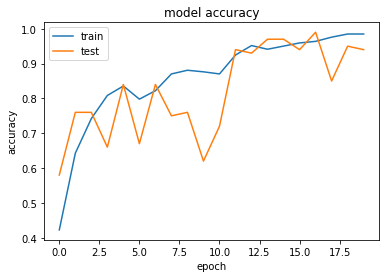

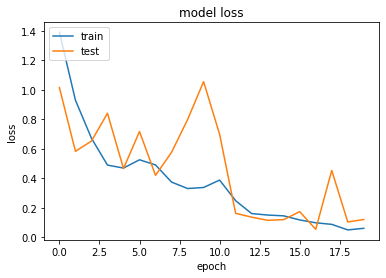

In [193]:
# Plotting the result of Model 11:

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [194]:
df1 = model_result("mobileNetModelWeight",history.history['categorical_accuracy'][-1], history.history['loss'][-1] , history.history['val_categorical_accuracy'][-1], history.history['val_loss'][-1])

model_detail_df = pd.concat([model_detail_df,df1])
print(model_detail_df.head(20))

             Model Name  Model Accuracy  Model Loss  Val Accuracy    Val Loss
0         modelConv3D_1       44.494721  136.417484     25.999999  219.879627
0         modelConv3D_2       38.612369  153.423560     30.000001  178.754282
0         modelConv3D_2       38.612369  153.423560     30.000001  178.754282
0         modelConv3D_3       42.986426  145.889616     31.000000  177.600634
0         modelConv3D_4       45.248869  134.927368     36.000001  141.790569
0         modelConv3D_5       59.125191  101.061988     52.999997  128.816605
0         modelConv3D_6       80.090499   55.362916     69.999999   83.913064
0             CNNlstm_1       92.458522   25.206617     77.999997   66.047078
0             CNNlstm_2       92.458522   25.206617     77.999997   66.047078
0             CNNlstm_3       85.972852   40.237352     79.000002   70.206344
0              GRU_lstm       90.196079   24.359199     74.000001   63.145792
0        mobileNetModel       99.396682    2.035408     72.00000

# Final Model Choosen :

## Transfer Learning with GRU and training all weights
#### model name :model-00017-0.09792-0.96380-0.05383-0.99000
#### Train Accuracy : 98.5% and Validation Accuracy : 94%

### *************************************************** END OF CASE STUDY *********************************************************